# COVID-19 SciVis

### Imports

In [19]:
import cartopy as ctpy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import numpy as npcreate_product
import pandas as pd

import os
import datetime
import geopandas
import cv2 
import multiprocessing

from cartopy.io import shapereader
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import bwr
from matplotlib.colors import TwoSlopeNorm

from read_data import *
from create_product import *

### Constants

In [6]:
# Make sure you initalized the submodule. Using a submodule allows us to get most up to date data more easily!
OUTPUT_PATH = "out"

### Loading COVID Data

In [7]:
data, timesteps = get_daily_data()

print(timesteps[0])
print(data[timesteps[0]])

03-01-2020
                                 province         country      lat       lon  \
0                                   Hubei  Mainland China  30.9756  112.2707   
1                                     NaN     South Korea  36.0000  128.0000   
2                                     NaN           Italy  43.0000   12.0000   
3                               Guangdong  Mainland China  23.3417  113.4244   
4                                   Henan  Mainland China  33.8820  113.6140   
..                                    ...             ...      ...       ...   
120                             Tempe, AZ              US  33.4255 -111.9400   
121                 From Diamond Princess       Australia  35.4437  139.6380   
122  Lackland, TX (From Diamond Princess)              US  29.3829  -98.6134   
123     Omaha, NE (From Diamond Princess)              US  41.2545  -95.9758   
124    Travis, CA (From Diamond Princess)              US  38.2721 -121.9399   

     confirmed  deaths  reco

In [4]:
# calculate the locational maximum for all points in the dataset
def calc_max_lat_lon():
    max_active_lat_lon = {}
    for t in timesteps:
        data_t = data[t]
        for index, row in data_t.iterrows():
            lat_lon_str = f"{row['lat']}:{row['lon']}"
            active = row['active']
            if lat_lon_str in max_active_lat_lon:
                if active > max_active_lat_lon[lat_lon_str]:
                    max_active_lat_lon[lat_lon_str] = active
            else:
                max_active_lat_lon[lat_lon_str] = active
    return max_active_lat_lon

# max_active_lat_lon = calc_max_lat_lon()
# Report the active case maximum for Hubei, China
print(max_active_lat_lon['30.9756:112.2707'])

32610


In [9]:
# Create a derivative dataset that includes change from previous day as a new column

def get_active_diff(last_day, this_day):
    active_diff = {}
    for lat_lon, today_val in this_day.items():
        if lat_lon in last_day:
            active_diff[lat_lon] = today_val - last_day[lat_lon]
        else:
            active_diff[lat_lon] = today_val
    return active_diff

def get_diff_data():
    data_diff = data
    for t in timesteps:
        data_diff[t]['diff'] = 0
    last_day_active = {}
    for t in timesteps:
        print(f"Getting diff for timestep {t}")
        data_t = data[t]
        this_day_active = {}
        for index, row in data_t.iterrows():
            lat_lon_str = f"{row['lat']}:{row['lon']}"
            active = row['active']
            this_day_active[lat_lon_str] = active
        location_diffs = get_active_diff(last_day_active, this_day_active)
        for lat_lon_str, diff in location_diffs.items():
            lat = float(lat_lon_str.split(':')[0])
            lon = float(lat_lon_str.split(':')[1])
            loc = data_diff[t].index[(data_diff[t]['lat'] == lat) & (data_diff[t]['lon'] == lon)]
            data_diff[t].at[loc, 'diff'] = diff
        last_day_active = this_day_active
    return data_diff

# data_diff = get_diff_data()
print(data_diff[timesteps[-2]])
print(data_diff[timesteps[-1]])

Getting diff for timestep 03-01-2020
Getting diff for timestep 03-02-2020
Getting diff for timestep 03-03-2020
Getting diff for timestep 03-04-2020
Getting diff for timestep 03-05-2020
Getting diff for timestep 03-06-2020
Getting diff for timestep 03-07-2020
Getting diff for timestep 03-08-2020
Getting diff for timestep 03-09-2020
Getting diff for timestep 03-10-2020
Getting diff for timestep 03-11-2020
Getting diff for timestep 03-12-2020
Getting diff for timestep 03-13-2020
Getting diff for timestep 03-14-2020
Getting diff for timestep 03-15-2020
Getting diff for timestep 03-16-2020
Getting diff for timestep 03-17-2020
Getting diff for timestep 03-18-2020
Getting diff for timestep 03-19-2020
Getting diff for timestep 03-20-2020
Getting diff for timestep 03-21-2020
Getting diff for timestep 03-22-2020
Getting diff for timestep 03-23-2020
Getting diff for timestep 03-24-2020
Getting diff for timestep 03-25-2020
Getting diff for timestep 03-26-2020
Getting diff for timestep 03-27-2020
G

Getting diff for timestep 10-09-2020
Getting diff for timestep 10-10-2020
Getting diff for timestep 10-11-2020
Getting diff for timestep 10-12-2020
Getting diff for timestep 10-13-2020
Getting diff for timestep 10-14-2020
Getting diff for timestep 10-15-2020
Getting diff for timestep 10-16-2020
Getting diff for timestep 10-17-2020
Getting diff for timestep 10-18-2020
Getting diff for timestep 10-19-2020
Getting diff for timestep 10-20-2020
Getting diff for timestep 10-21-2020
Getting diff for timestep 10-22-2020
Getting diff for timestep 10-23-2020
Getting diff for timestep 10-24-2020
Getting diff for timestep 10-25-2020
Getting diff for timestep 10-26-2020
Getting diff for timestep 10-27-2020
Getting diff for timestep 10-28-2020
Getting diff for timestep 10-29-2020
Getting diff for timestep 10-30-2020
Getting diff for timestep 10-31-2020
Getting diff for timestep 11-01-2020
Getting diff for timestep 11-02-2020
Getting diff for timestep 11-03-2020
Getting diff for timestep 11-04-2020
G

In [38]:
# Load aircraft data
# https://zenodo.org/record/4670228

# Find airports of interest
# For each day, count up incoming and outgoing
# Format date strings mm-dd-yyy

# Resulting table for each day-> airport (ICAO), lat, lon, incoming, outgoing

# Top 10 major airports and SLC just for kicks

major_us_airports = ['KATL','KLAX','KORD','KDFW','KDEN','KJFK','KSFO','KLAS','KSEA','KCLT', 'KSLC']

def get_period_data(flight_csv):
    airport_csv_path = os.path.join('flightData', flight_csv)
    airport_data = pd.read_csv(airport_csv_path)
    airport_incoming_outgoing = {}
    for a in major_us_airports:
        a_data_origin = airport_data[airport_data['origin'] == a]
        a_data_dest = airport_data[airport_data['destination'] == a]

        # Find unique days
        end_times = a_data_origin['lastseen'].to_numpy()
        end_dates = list(set([d.split(' ')[0] for d in end_times]))
        end_dates.sort()
        
        # print(f"{a} - Incoming: {a_data_dest.shape[0]}, Outgoing: {a_data_origin.shape[0]}")
        # Find the incoming and outgoing for those days
        
        dates_incoming_outgoing = {}
        for d in end_dates:
            incoming_d = a_data_dest[a_data_dest['lastseen'].str.contains(d)].shape[0]
            outgoing_d = a_data_origin[a_data_origin['firstseen'].str.contains(d)].shape[0]
            # print(f"{a} - {d}  - Incoming: {incoming_d}, Outgoing: {outgoing_d}")
            s = d.split('-')
            format_d = f"{s[1]}-{s[2]}-{s[0]}"
            dates_incoming_outgoing[format_d] = (incoming_d, outgoing_d)
        airport_incoming_outgoing[a] = dates_incoming_outgoing

    return airport_incoming_outgoing

def load_flight_data():
    flights_csvs = [f for f in os.listdir('flightData') if os.path.splitext(f)[1] == '.csv']
    flights_csvs.sort()

    all_time_flight_data = []
    for flight_csv in flights_csvs:
        # This ensures that we do not load EVERY flight dataset into memory perminantly. That would be BAD
        with multiprocessing.Pool(1) as pool: 
            result = pool.map(get_period_data, [flight_csv])[0]
            all_time_flight_data.append(result)
        print(f"Finished loading flight data from {flight_csv}")

    # Aggrigate all of the flight data into a map of timestamps to a dataframe of 
    # [airport, lat, lon, in, out]

    airport_geocoords = {'KATL': (33.6407, -84.4277),
                         'KLAX': (33.9416, -118.4085),
                         'KORD': (41.9803, -87.9090),
                         'KDFW': (32.8998, -97.0403),
                         'KDEN': (39.8561, -104.6737),
                         'KJFK': (40.6413, -73.7781),
                         'KSFO': (37.6213, -122.3790),
                         'KLAS': (36.0840, -115.1537),
                         'KSEA': (47.4502, -122.3088),
                         'KCLT': (35.2144, -80.9473), 
                         'KSLC': (40.7899, -111.9791)}

    airport_data = { day: pd.DataFrame(columns = ["airport", "lat", "lon", "in", "out"]) for day in timesteps }
    for a in major_us_airports:
        all_for_airport = [month_data[a] for month_data in all_time_flight_data]
        all_for_airport_aggrigate = {date: income_outcome for d in all_for_airport for date, income_outcome in d.items()}
        for day, in_out in all_for_airport_aggrigate.items():
            if day in airport_data:
                lat = airport_geocoords[a][0]
                lon = airport_geocoords[a][1]
                airport_data[day].loc[len(airport_data[day].index)] = [a, lat, lon, in_out[0], in_out[1]]

    return airport_data
            
airport_data = load_flight_data()
print(airport_data[timesteps[0]])

Finished loading flight data from flightlist_20200301_20200331.csv
Finished loading flight data from flightlist_20200401_20200430.csv
Finished loading flight data from flightlist_20200501_20200531.csv
Finished loading flight data from flightlist_20200601_20200630.csv
Finished loading flight data from flightlist_20200701_20200731.csv
Finished loading flight data from flightlist_20200801_20200831.csv
Finished loading flight data from flightlist_20200901_20200930.csv
Finished loading flight data from flightlist_20201001_20201031.csv
Finished loading flight data from flightlist_20201101_20201130.csv
Finished loading flight data from flightlist_20201201_20201231.csv
Finished loading flight data from flightlist_20210101_20210131.csv
Finished loading flight data from flightlist_20210201_20210228.csv
Finished loading flight data from flightlist_20210301_20210331.csv
[{'KATL': {'03-01-2020': (1035, 1069), '03-02-2020': (1239, 1250), '03-03-2020': (1257, 1248), '03-04-2020': (1257, 1241), '03-05

In [86]:
def calc_max_in_out():
    max_in_out = {}
    for t in timesteps:
        airport_data_t = airport_data[t]
        for index, row in airport_data_t.iterrows():
            airport = row['airport']
            in_val = row['in']
            out_val = row['out']
            if airport in max_in_out:
                if in_val > max_in_out[airport][0]:
                    max_in_out[airport][0] = in_val
                if out_val > max_in_out[airport][1]:
                    max_in_out[airport][1] = out_val
            else:
                max_in_out[airport] = [in_val, out_val]
    return max_in_out

def calc_max_in_out_all(max_in_out):
    max_in_out_all = [0,0]
    
    for airport, max_in_out in max_in_out.items():
        max_in = max_in_out[0]
        max_out = max_in_out[1]
        if max_in > max_in_out_all[0]:
            max_in_out_all[0] = max_in
        if max_out > max_in_out_all[1]:
            max_in_out_all[1] = max_out
    
    return max_in_out_all

max_in_out = calc_max_in_out()
max_in_out_all = calc_max_in_out_all(max_in_out)
# Report the incoming and outgoing flight maximums for KSLC
print(max_in_out['KSLC'])
print(max_in_out_all)

[468, 439]
[1316, 1324]


### Example figure

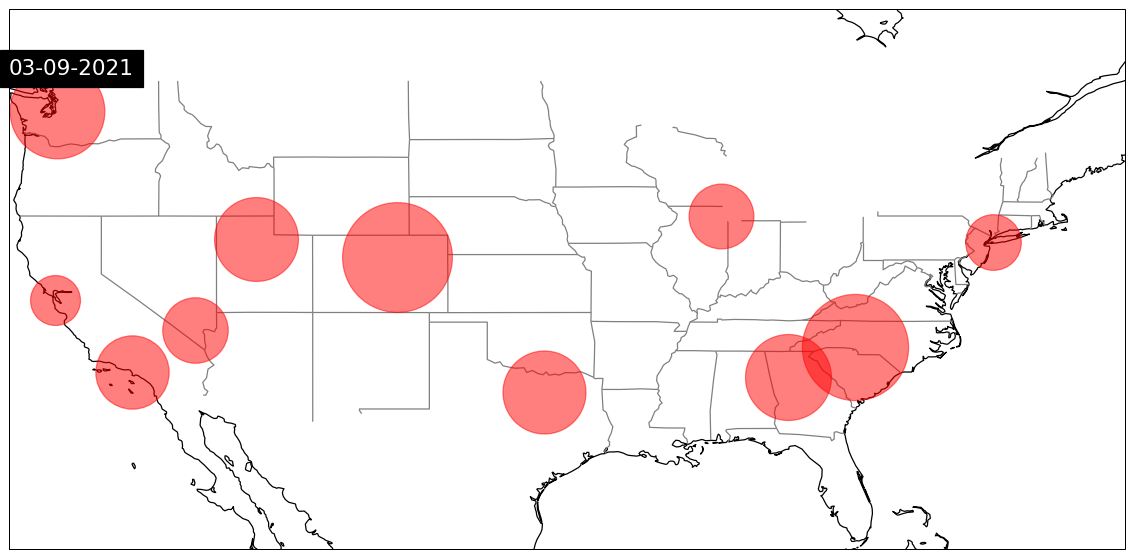

In [62]:
def is_in_extent(pt, extent_lat, extent_lon):
    return pt[0] >= extent_lat[0] and pt[0] <= extent_lat[1] and pt[1] >= extent_lon[0] and pt[1] <= extent_lon[1]

def example_fig(d, t, local_max, extent_lat, extent_lon, max_size = 100):
    # Create the figure
    fig = plt.figure(figsize=(16,8), dpi=90)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([extent_lon[0],extent_lon[1],extent_lat[0],extent_lat[1]])
    ax.coastlines()

    # This adds the US state borders
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    
    for index, row in d[t].iterrows():
        lat = row['lat']
        lon = row['lon']
        if is_in_extent((lat, lon), extent_lat, extent_lon):
            #active = row['active']
            #lat_lon_str = f"{lat}:{lon}"
            in_val = row['in']
            out_val = row['in']
            airport = row['airport']
            # Some local maximum are 0... fishy china
            #if local_max[lat_lon_str] > 0:
            if local_max[airport][0] > 0:
                # active_norm = active/local_max[lat_lon_str]
                norm_in = in_val / local_max[airport][0]
                mark_size = norm_in * max_size
                ax.plot(lon, lat, 'ro', markersize=mark_size, transform=ccrs.PlateCarree(), alpha=0.5)

    plt.text(extent_lon[0],extent_lat[1], t, backgroundcolor="black", color="white", fontsize="xx-large", zorder=100, transform=ccrs.PlateCarree())

    plt.show()
    
us_extent_lat = (24.7433195, 49.3457868)
us_extent_lon = (-124.7844079, -66.9513812)
example_fig(airport_data, timesteps[-1], max_in_out, us_extent_lat, us_extent_lon)

In [99]:
def create_mesh(lats, lons, vals, extent_lat, extent_lon, res):
    """
    Creates a 2D mesh of the data contained in vals at the corresponding points in lats and lons 
    
    Assumes lats, lons and vals are 1D arrays of the same size
    
    Res must be a multiple of 10. Other values are not guaranted to work! 
    x.0      - Lower resolution
    1.0      - Country or large region
    0.1      - Large city or district
    0.01     - Town or village
    0.001    - Neighborhood, street
    0.0001   - Individual street, large buildings
    0.00001  - Individual trees, houses
    0.000001 - Individual humans
    """
    
    extent_w = extent_lon[1] - extent_lon[0]
    extent_h = extent_lat[1] - extent_lat[0]
    
    mesh_w = int(extent_w/res)
    mesh_h = int(extent_h/res)
    
    lats_mesh = np.linspace(extent_lat[0],extent_lat[1], mesh_h)
    lons_mesh = np.linspace(extent_lon[0],extent_lon[1], mesh_w)
    
    mesh = np.zeros((mesh_h, mesh_w))
        
    # Set all mesh values
    for i in range(vals.shape[0]):
        lat = lats.iloc[i]
        lon = lons.iloc[i]
        
        if is_in_extent((lat,lon), extent_lat, extent_lon):
            val = vals.iloc[i]
            mesh_lat = int(((extent_lat[1] - lat)/extent_h)*mesh_h)
            mesh_lon = int(((extent_lon[1] - lon)/extent_w)*mesh_w)
            mesh[mesh_lat, mesh_lon] += val
    
    mesh = np.rot90(np.rot90(mesh))
    mesh = cv2.GaussianBlur(mesh,(11,11),0)
    return lats_mesh, lons_mesh, mesh

# The country masking code is courtesy of:
# https://stackoverflow.com/a/62502422/7759262
def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]

# The shifted colormap code is courtesy of:
# https://stackoverflow.com/a/20528097/7759262
def get_shifted_cmap(cmap, start=0.0, midpoint=0.5, stop=1.0):
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = LinearSegmentedColormap("newColormap", cdict)
    return newcmap

def contour(data, timesteps, step, extent_lat, extent_lon, res):
    """
    Creates a contour figure for the given timestep "step"
    """
    time = timesteps[step]
    data_t = data[time]
    lats = data_t['lat']
    lons = data_t['lon']
    vals = data_t['diff']
    
    # Create the figure
    fig = plt.figure(figsize=(16,8), dpi=90)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([extent_lon[0],extent_lon[1],extent_lat[0],extent_lat[1]])
    
    # Plot map features
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='black', facecolor='none'))
    ax.add_feature(ctpy.feature.LAKES, zorder=99, edgecolor='black')
    ax.add_feature(ctpy.feature.BORDERS, zorder=99, edgecolor='black')
    geom_data = geopandas.read_file(shapereader.natural_earth('110m', 'cultural', 'admin_0_countries'))
    us_poly = [geom_data.loc[geom_data['ADMIN'] == 'United States of America']['geometry'].values[0]]
    us_mask = Polygon(rect_from_bound(*us_poly[0].bounds)).difference( us_poly[0].simplify(0.01) )
    us_mask_projected = ccrs.PlateCarree().project_geometry(us_mask, ccrs.PlateCarree())
    ax.add_geometries(us_mask_projected, ccrs.PlateCarree(), zorder=99, facecolor='white', edgecolor='none', alpha=1.0)

    # Get the mesh and plot it
    lats_mesh, lons_mesh, val_mesh = create_mesh(lats, lons, vals, extent_lat, extent_lon, res)
    plt.contourf(lons_mesh, lats_mesh, val_mesh, 256, cmap='bwr', transform=ccrs.PlateCarree())

    # Suplement with airport info
    airport_data_t = airport_data[time]
    for index, row in airport_data_t.iterrows():
        airport_lat = row['lat']
        airport_lon = row['lon']
        incoming_flights = row['in']
        airport = row['airport']
        norm_incoming = incoming_flights / max_in_out_all[0]
        mark_size = norm_incoming * 50
        ax.plot(airport_lon, airport_lat, 'wo', markersize=mark_size, transform=ccrs.PlateCarree(), alpha=1.0, fillstyle='none')
        plt.text(airport_lon,airport_lat, airport, color="black", fontsize="large", zorder=100, transform=ccrs.PlateCarree())
    
    # Add date stamp
    plt.text(extent_lon[0],extent_lat[1], time, backgroundcolor="black", color="white", fontsize="xx-large", zorder=100, transform=ccrs.PlateCarree())

    return fig


### Generate sample for testing

In [100]:
us_extent_lat = (24.7433195, 49.3457868)
us_extent_lon = (-124.7844079, -66.9513812)
resolution = 0.25

test_imgs = []
test_timesteps = timesteps[-100:-90]
for t in range(len(test_timesteps)):
    fig = contour(data, test_timesteps, t, us_extent_lat, us_extent_lon, resolution)
    fig.savefig(f"{OUTPUT_PATH}/contour_test_{t}.png", format='png')
    img = plt_to_img(fig)
    test_imgs.append(img)

    # Preserve memory by removing figures. No need to retain them
    plt.clf()
    plt.close(fig)
    
imgs_to_video(test_imgs, f"{OUTPUT_PATH}/contour_test_ideo.avi", framerate=1)

### Generate images

In [101]:
imgs = []
for t in range(len(timesteps)):
    fig = contour(data, timesteps, t, us_extent_lat, us_extent_lon, resolution)
    fig.savefig(f"{OUTPUT_PATH}/contour_{t}.png", format='png')
    img = plt_to_img(fig)
    imgs.append(img)

    # Preserve memory by removing figures. No need to retain them
    plt.clf()
    plt.close(fig)

### Generate video

In [102]:
imgs_to_video(imgs, f"{OUTPUT_PATH}/contour_video.avi", framerate=15)